In [22]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

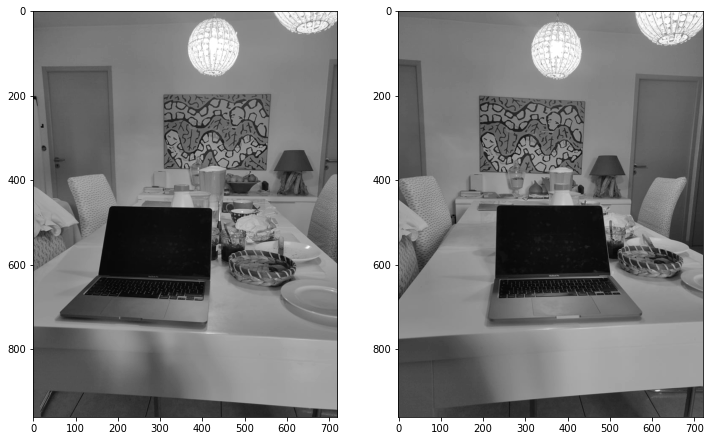

In [20]:
img_1 = cv2.imread("img_left.jpg", cv2.IMREAD_GRAYSCALE)
img_2 = cv2.imread("img_right.jpg", cv2.IMREAD_GRAYSCALE)

fig = plt.figure(figsize=(12, 12))
ax_1 = fig.add_subplot(121)
ax_2 = fig.add_subplot(122)

ax_1.imshow(img_1, cmap="gray");
ax_2.imshow(img_2, cmap="gray");

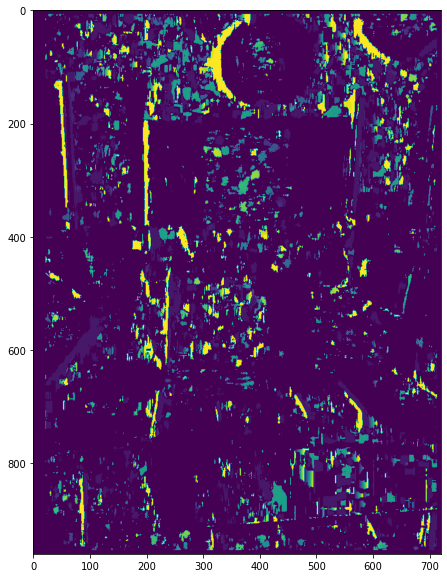

In [34]:
stereo = cv2.StereoBM_create(
    numDisparities=16,
    blockSize=15,
)
disp = stereo.compute(img_1, img_2).astype(np.float32)
disp = cv2.normalize(disp, 0, 255, cv2.NORM_MINMAX)


fig = plt.figure(figsize=(10, 10)) 
ax = fig.add_subplot(111)
ax.imshow(disp);#, cmap="gray");

In [63]:
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape
    img1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv2.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv2.circle(img2,tuple(pt2),5,color,-1)
    return img1,img2

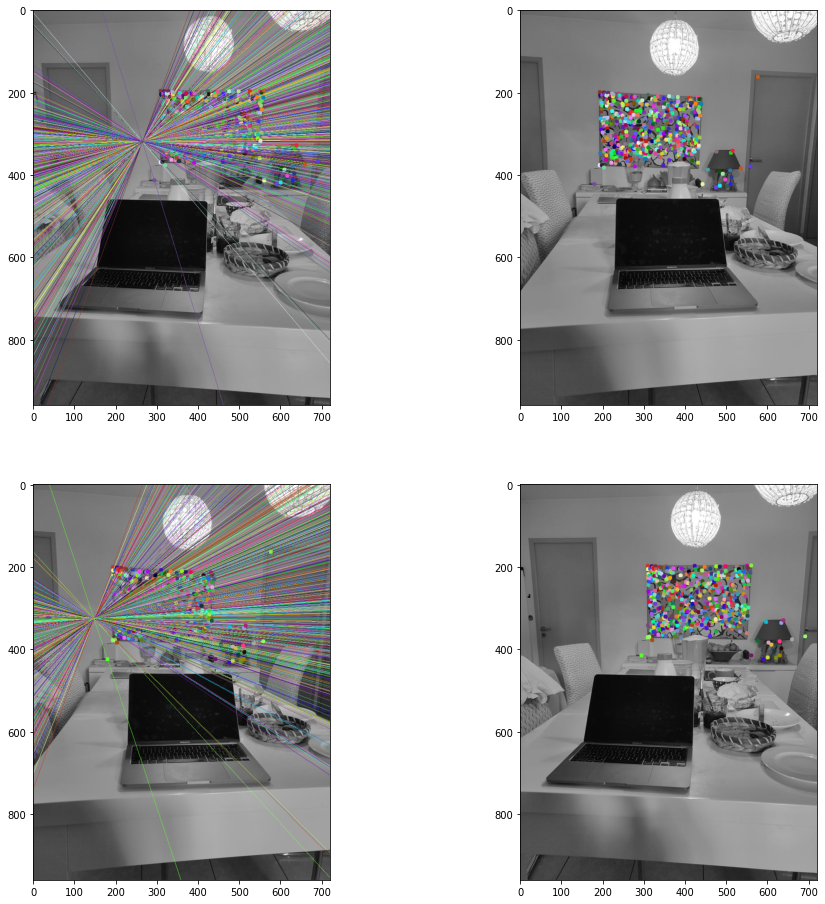

In [66]:
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(img_1, None)
kp2, des2 = sift.detectAndCompute(img_2, None)

FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1 , des2, k=2)

pts1 = []
pts2 = []
# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.8*n.distance:
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)
        
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_LMEDS)
# We select only inlier points
pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]

lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2, F)
lines1 = lines1.reshape(-1,3)
img5, img6 = drawlines(img_1, img_2, lines1, pts1, pts2)

lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1, F)
lines2 = lines2.reshape(-1,3)
img3, img4 = drawlines(img_2, img_1, lines2, pts2, pts1)

fig = plt.figure(figsize=(16, 16))
ax_1 = fig.add_subplot(221)
ax_2 = fig.add_subplot(222)
ax_3 = fig.add_subplot(223)
ax_4 = fig.add_subplot(224)

ax_1.imshow(img5)
ax_2.imshow(img6)
ax_3.imshow(img3)
ax_4.imshow(img4)